In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"  # specify which GPU(s) to be used

import warnings
warnings.filterwarnings('ignore')

import ipywidgets as widgets
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import time
import gc
from scipy.spatial.distance import cosine
import json
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import transformers
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import Callback 
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors

tf.get_logger().setLevel('ERROR')

In [2]:
tf.__version__, transformers.__version__

('2.3.0', '4.3.3')

In [6]:
MIN_CLASS_SIZE = -1
DATA_LIST = ['LC-QuAD', 'QALD', 'CogComp', 'WebQuestions', 'SimpleQuestions']
CLASS_NAMES = [
    'List',
    'Award',
    'Disease',
    'Boolean',
    'EthnicGroup',
    'Event',
    'Work',
    'TimePeriod',
    'DateTime',
    'Flag',
    'Holiday',
    'ChemicalSubstance',
    'Currency',
    'PersonFunction',
    'SportsSeason',
    'Activity',
    'Medicine',
    'Species',
    'Altitude',
    'Colour',
    'Device',
    'Language',
    'Number',
    'MeanOfTransportation',
    'Food',
    'TopicalConcept',
    'AnatomicalStructure',
    'Agent',
    'Place',
    'String'
]

TRAIN_LIST = ['LC-QuAD',
                'QALD',
                'CogComp',
                'WebQuestions',
                'SimpleQuestions',
                'LC-QuAD+QALD',
                'LC-QuAD+CogComp',
                'LC-QuAD+WebQuestions',
                'LC-QuAD+SimpleQuestions',
                'QALD+CogComp',
                'QALD+WebQuestions',
                'QALD+SimpleQuestions',
                'CogComp+WebQuestions',
                'CogComp+SimpleQuestions',
                'WebQuestions+SimpleQuestions',
                'LC-QuAD+QALD+CogComp',
                'LC-QuAD+QALD+WebQuestions',
                'LC-QuAD+QALD+SimpleQuestions',
                'LC-QuAD+CogComp+WebQuestions',
                'LC-QuAD+CogComp+SimpleQuestions',
                'LC-QuAD+WebQuestions+SimpleQuestions',
                'QALD+CogComp+WebQuestions',
                'QALD+CogComp+SimpleQuestions',
                'QALD+WebQuestions+SimpleQuestions',
                'CogComp+WebQuestions+SimpleQuestions',
                'LC-QuAD+QALD+CogComp+WebQuestions',
                'LC-QuAD+QALD+CogComp+SimpleQuestions',
                'LC-QuAD+QALD+WebQuestions+SimpleQuestions',
                'LC-QuAD+CogComp+WebQuestions+SimpleQuestions',
                'QALD+CogComp+WebQuestions+SimpleQuestions',
                'LC-QuAD+QALD+CogComp+WebQuestions+SimpleQuestions']

TEST_LIST = ['LC-QuAD', 'QALD', 'CogComp', 'WebQuestions', 'SimpleQuestions']

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [59]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts,
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )
    
    return np.array(enc_di['input_ids'])

In [12]:
model = tf.keras.models.load_model("../../../bin_eat/classifier")

encoder = LabelEncoder()
encoder.classes_ = np.load('../../../bin_eat/encoder.npy', allow_pickle=True)

In [13]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 128)]             0         
_________________________________________________________________
distilbert (TFDistilBertMain TFBaseModelOutput(last_hi 66362880  
_________________________________________________________________
tf_op_layer_strided_slice (T (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                24608     
Total params: 66,387,488
Trainable params: 66,387,488
Non-trainable params: 0
_________________________________________________________________


In [14]:
embedding_model = Model(inputs=[model.get_layer("input_word_ids").input], 
                outputs=[model.get_layer("tf_op_layer_strided_slice").output])

In [79]:
error_dict = {key: None for key in DATA_LIST}

for data in DATA_LIST:
    print(data)
    
    df = pd.read_csv(f"../../data/UnifiedSubclassDBpedia/{data}-train.csv", sep=';')
    
    questions = regular_encode(list(df.questionText.astype(str).values), tokenizer, maxlen=128)
    dataset = (
        tf.data.Dataset
        .from_tensor_slices(questions)
        .batch(16)
    )
    result = embedding_model.predict(dataset)
    
    # calculate cluster centers
    cluster_centers = {key: None for key in df.type.unique()}

    for label in df.type.unique():
        tmp = np.append(result, np.array([[i] for i in df.type.values]), axis=1)
        tmp = tmp[np.where(tmp[:,768] == label)[0],:768]
        cluster_centers[label] = np.mean(tmp.astype(float), axis=0)
        
    # calculate cluster diameters 95th percentile
    """cluster_diameters = {key: None for key in df.type.unique()}
    cluster_diameters_95th = {key: None for key in df.type.unique()}
    
    # iterate over labels and find data points with wrong cluster center
    for label in df.type.unique():
        tmp = np.append(result, np.array([[i] for i in df.type.values]), axis=1)
        tmp = tmp[np.where(tmp[:,768] == label)[0],:768] # get only class vectors
        diameters = list()
        for vector in tmp: # calculate distances between all vectors
            diameters.append(cosine(cluster_centers[label], vector.astype(float)))
        cluster_diameters[label] = max(diameters)
        cluster_diameters_95th[label] = np.percentile(diameters, 25)
        
    assert cluster_diameters['Agent'] > cluster_diameters_95th['Agent']"""
    
    # iterate over dataset and find data points with wrong cluster center
    error_stats = {key: None for key in df.type.unique()}
    for label in df.type.unique():
        tmp = np.append(result, np.array([[i] for i in df.type.values]), axis=1) 
        tmp = np.append(tmp, np.array([[i] for i in df.questionText.values]), axis=1)
        tmp = tmp[np.where(tmp[:,768] == label)[0],:] # get only class vectors
        
        errors = list()
        if tmp.shape[0] <= MIN_CLASS_SIZE:
            error_stats[label] = errors
            continue
        
        for i in range(len(tmp)):
            # if cosine(cluster_centers[label], tmp[i,:768].astype(float)) > cluster_diameters_95th[label]:
                # detect proposed class label
            min_val, min_lbl = 1*10**100000, None
            for label_tmp in df.type.unique():
                if cosine(cluster_centers[label_tmp], tmp[i,:768].astype(float)) < min_val:
                    min_val = cosine(cluster_centers[label_tmp], tmp[i,:768].astype(float))
                    min_lbl = label_tmp
            if min_lbl != label:
                errors.append((tmp[i,769], min_lbl))
                
        error_stats[label] = errors
    
    error_dict[data] = error_stats
    
    # np.savetxt(f"../../data/embeddings/{data}_embeddings", result, delimiter='\t')
    # np.savetxt(f"../../data/embeddings/{data}_labels", df.type.values, delimiter='\t', fmt="%s")

LC-QuAD
QALD
CogComp
WebQuestions
SimpleQuestions


In [80]:
cnt = 0
df = pd.read_csv(f"../../data/UnifiedSubclassDBpedia/LC-QuAD-train.csv", sep=';')
for k in list(error_dict['LC-QuAD'].keys()):
    if df[df.type == k].shape[0] > MIN_CLASS_SIZE:
        # print(k, len(error_dict['WebQuestions'][k])/ df[df.type == k].shape[0]*100)
        cnt += len(error_dict['LC-QuAD'][k])
    else:
        cnt+= 0
print(cnt, cnt/df.shape[0]*100)

24 1.284796573875803


In [81]:
cnt = 0
df = pd.read_csv(f"../../data/UnifiedSubclassDBpedia/QALD-train.csv", sep=';')
for k in list(error_dict['QALD'].keys()):
    if df[df.type == k].shape[0] > MIN_CLASS_SIZE:
        # print(k, len(error_dict['WebQuestions'][k])/ df[df.type == k].shape[0]*100)
        cnt += len(error_dict['QALD'][k])
    else:
        cnt+= 0
print(cnt, cnt/df.shape[0]*100)

14 3.5623409669211195


In [82]:
cnt = 0
df = pd.read_csv(f"../../data/UnifiedSubclassDBpedia/CogComp-train.csv", sep=';')
for k in list(error_dict['CogComp'].keys()):
    if df[df.type == k].shape[0] > MIN_CLASS_SIZE:
        # print(k, len(error_dict['WebQuestions'][k])/ df[df.type == k].shape[0]*100)
        cnt += len(error_dict['CogComp'][k])
    else:
        cnt+= 0
print(cnt, cnt/df.shape[0]*100)

125 3.3756413718606533


In [83]:
cnt = 0
df = pd.read_csv(f"../../data/UnifiedSubclassDBpedia/WebQuestions-train.csv", sep=';')
for k in list(error_dict['WebQuestions'].keys()):
    if df[df.type == k].shape[0] > MIN_CLASS_SIZE:
        # print(k, len(error_dict['WebQuestions'][k])/ df[df.type == k].shape[0]*100)
        cnt += len(error_dict['WebQuestions'][k])
    else:
        cnt+= 0
print(cnt, cnt/df.shape[0]*100)

105 3.541315345699832


In [84]:
cnt = 0
df = pd.read_csv(f"../../data/UnifiedSubclassDBpedia/SimpleQuestions-train.csv", sep=';')
for k in list(error_dict['SimpleQuestions'].keys()):
    if df[df.type == k].shape[0] > MIN_CLASS_SIZE:
        # print(k, len(error_dict['WebQuestions'][k])/ df[df.type == k].shape[0]*100)
        cnt += len(error_dict['SimpleQuestions'][k])
    else:
        cnt+= 0
print(cnt, cnt/df.shape[0]*100)

1501 3.6303390896338215


In [95]:
matrix = list()

for name in DATA_LIST:
    row = list()
    df = pd.read_csv(f"../../data/UnifiedSubclassDBpedia/{name}-train.csv", sep=';')
    for label in CLASS_NAMES:
        if label in list(error_dict[name].keys()):
            row.append(len(error_dict[name][label])/df[df.type == label].shape[0]*100)
        else:
            row.append(0.0)
    matrix.append(row)

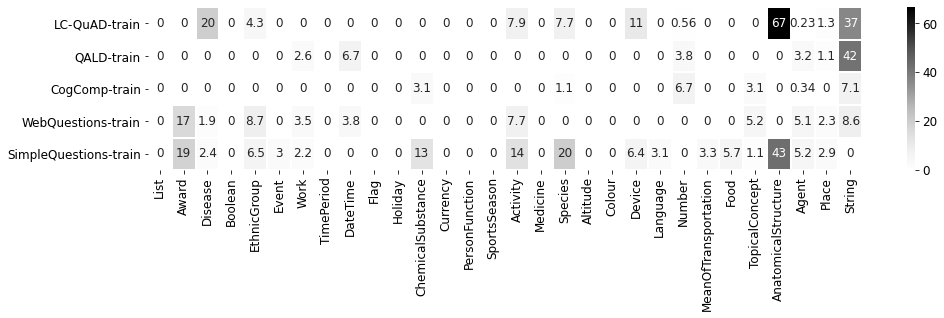

In [96]:
import matplotlib.pylab as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = [16,3]
plt.rcParams["font.size"] = 12

ax = sns.heatmap(
    np.array(matrix),
    linewidths=1,
    annot=True,
    xticklabels=CLASS_NAMES,
    yticklabels=[data + '-train' for data in DATA_LIST],
    cmap="Greys"
)
plt.yticks(rotation=0) 
plt.show()

In [97]:
with open("../../data/Insights/error_dict.json", 'w') as f:
    json.dump(error_dict, f, ensure_ascii=False, indent=4)

In [3]:
error_dict = None
with open("../../data/Insights/error_dict.json") as f:
    error_dict = json.load(f)

In [4]:
for data in DATA_LIST:
    question, label_, suggested = list(), list(), list()
    for label in list(error_dict[data].keys()):
        for q in error_dict[data][label]:
            question.append(q[0])
            label_.append(label)
            suggested.append(q[1])
            
    df = pd.DataFrame.from_dict({'question': question, 'label': label_, 'suggested': suggested})
    df.to_csv(f"../../data/error_analysis/{data}.csv", index=False, sep=';')

,question,label,suggested
0,what did james madison wrote?,Place,Work
1,what does the letters eu stand for?,Place,String
2,what each fold of the us flag means?,Place,Flag
3,what else is there in orlando besides disney?,Place,Activity
4,what is illinois state bird?,Place,Species
...,...,...,...
100,who is ruling tunisia now?,Activity,Agent
101,what date did the san francisco giants win the...,Award,DateTime
102,what nationality is jermaine paul?,EthnicGroup,Place
103,what nationality is zack de la rocha?,EthnicGroup,Place


In [52]:
error_dict['CogComp']['Language']

['What is the only modern language that capitalizes its singular first-person pronoun ?']

In [96]:
error_rates_dict = {
    'LC-QuAD': 96,
    'QALD': 21,
    'CogComp': 191,
    'WebQuestions': 153,
    'SimpleQuestions': 2075
}

In [102]:
train_lst, test_lst, value_lst = list(), list(), list()

for train in TRAIN_LIST:
    for test in TEST_LIST:
        error_cnt = 0
        for ds in train.split('+'):
            error_cnt+=error_rates_dict[ds]
            
        value_lst.append(error_cnt)
        train_lst.append(train)
        test_lst.append(test)

In [104]:
df = pd.DataFrame.from_dict({'train': train_lst, 'test': test_lst, 'value': value_lst})

In [105]:
df.to_csv("../../data/KL-divergence/error_abs.csv", sep='$', index=False)